Splice junctions are points on a DNA sequence at which `superfluous' DNA is removed during the process of protein creation in higher organisms. The problem posed in this dataset is to recognize, given a sequence of DNA, the boundaries between exons (the parts of the DNA sequence retained after splicing) and introns (the parts of the DNA sequence that are spliced out). This problem consists of two subtasks: recognizing exon/intron boundaries (referred to as EI sites), and recognizing intron/exon boundaries (IE sites). (In the biological community, IE borders are referred to a ``acceptors'' while EI borders are referred to as ``donors''.)

Attribute Information:

* 1. One of {n ei ie}, indicating the class.
* 2. The instance name.
* 3-62. The remaining 60 fields are the sequence, starting at position -30 and ending at position +30. Each of these fields is almost always filled by one of {a, g, t, c}. Other characters indicate ambiguity among the standard characters according to the following table:


In [1]:
import pandas as pd 
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.metrics import f1_score
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.model_selection import train_test_split
from sklearn.metrics import confusion_matrix
from mlxtend.plotting import plot_confusion_matrix
from tensorflow.keras.utils import to_categorical
import tensorflow as tf
tf.config.run_functions_eagerly(True)
import time

In [2]:
# size of our kmer words
k_mer = 7
# dimesnion space of our embedding layer
EMB_DIM = 50

#### reading and exploring the data

In [3]:
splice_data = pd.read_csv('splice.data', header=None, names = ['class', 'donor', 'sequence'])
splice_data.head()

,class,donor,sequence
0,EI,ATRINS-DONOR-521,CCAGCTGCATCACAGGAGGCCAGCGAGCAGG...
1,EI,ATRINS-DONOR-905,AGACCCGCCGGGAGGCGGAGGACCTGCAGGG...
2,EI,BABAPOE-DONOR-30,GAGGTGAAGGACGTCCTTCCCCAGGAGCCGG...
3,EI,BABAPOE-DONOR-867,GGGCTGCGTTGCTGGTCACATTCCTGGCAGGT...
4,EI,BABAPOE-DONOR-2817,GCTCAGCCCCCAGGTCACCCAGGAACTGACGTG...


In [4]:
# we have 3 classes in this dataset
CLASS_NUM = 3

In [5]:
len(splice_data)

3190

In [6]:
splice_data['sequence'] = splice_data.apply(lambda x: str(x['sequence']), axis=1)
splice_data.head()

,class,donor,sequence
0,EI,ATRINS-DONOR-521,CCAGCTGCATCACAGGAGGCCAGCGAGCAGG...
1,EI,ATRINS-DONOR-905,AGACCCGCCGGGAGGCGGAGGACCTGCAGGG...
2,EI,BABAPOE-DONOR-30,GAGGTGAAGGACGTCCTTCCCCAGGAGCCGG...
3,EI,BABAPOE-DONOR-867,GGGCTGCGTTGCTGGTCACATTCCTGGCAGGT...
4,EI,BABAPOE-DONOR-2817,GCTCAGCCCCCAGGTCACCCAGGAACTGACGTG...


In [7]:
splice_data['class'].value_counts()

N     1655
IE     768
EI     767
Name: class, dtype: int64

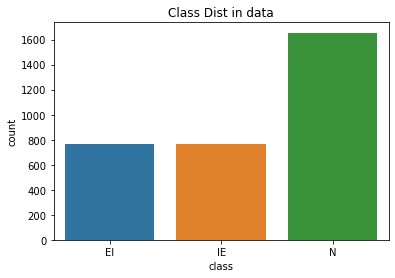

In [8]:
sns.countplot(x =splice_data['class'])
plt.title("Class Dist in data")
plt.show()

In [9]:
def kmer_fun(seq, win_size):
    kmer_list = []
    for x in range(len(seq) - win_size + 1):
        kmer_list.append(seq[x:x+win_size].lower())
    return kmer_list

#So let’s try it out with a simple sequence:
mySeq = 'CCAGCTG'
kmer_fun(mySeq, win_size= k_mer)

['ccagctg']

In [10]:
splice_data['sequence'] = splice_data.apply(lambda x : x['sequence'].strip(), axis = 1)
splice_data.head()

,class,donor,sequence
0,EI,ATRINS-DONOR-521,CCAGCTGCATCACAGGAGGCCAGCGAGCAGGTCTGTTCCAAGGGCC...
1,EI,ATRINS-DONOR-905,AGACCCGCCGGGAGGCGGAGGACCTGCAGGGTGAGCCCCACCGCCC...
2,EI,BABAPOE-DONOR-30,GAGGTGAAGGACGTCCTTCCCCAGGAGCCGGTGAGAAGCGCAGTCG...
3,EI,BABAPOE-DONOR-867,GGGCTGCGTTGCTGGTCACATTCCTGGCAGGTATGGGGCGGGGCTT...
4,EI,BABAPOE-DONOR-2817,GCTCAGCCCCCAGGTCACCCAGGAACTGACGTGAGTGTCCCCATCC...


In [11]:
splice_data[str(k_mer)+'-mer'] = splice_data.apply(lambda x : kmer_fun(x['sequence']
                                                    , win_size= k_mer), axis = 1)
splice_data.head()

,class,donor,sequence,7-mer
0,EI,ATRINS-DONOR-521,CCAGCTGCATCACAGGAGGCCAGCGAGCAGGTCTGTTCCAAGGGCC...,"[ccagctg, cagctgc, agctgca, gctgcat, ctgcatc, ..."
1,EI,ATRINS-DONOR-905,AGACCCGCCGGGAGGCGGAGGACCTGCAGGGTGAGCCCCACCGCCC...,"[agacccg, gacccgc, acccgcc, cccgccg, ccgccgg, ..."
2,EI,BABAPOE-DONOR-30,GAGGTGAAGGACGTCCTTCCCCAGGAGCCGGTGAGAAGCGCAGTCG...,"[gaggtga, aggtgaa, ggtgaag, gtgaagg, tgaagga, ..."
3,EI,BABAPOE-DONOR-867,GGGCTGCGTTGCTGGTCACATTCCTGGCAGGTATGGGGCGGGGCTT...,"[gggctgc, ggctgcg, gctgcgt, ctgcgtt, tgcgttg, ..."
4,EI,BABAPOE-DONOR-2817,GCTCAGCCCCCAGGTCACCCAGGAACTGACGTGAGTGTCCCCATCC...,"[gctcagc, ctcagcc, tcagccc, cagcccc, agccccc, ..."


In [12]:
from sklearn import preprocessing
le = preprocessing.LabelEncoder()
splice_data['class'] = le.fit_transform(splice_data['class'])
splice_data.head()

,class,donor,sequence,7-mer
0,0,ATRINS-DONOR-521,CCAGCTGCATCACAGGAGGCCAGCGAGCAGGTCTGTTCCAAGGGCC...,"[ccagctg, cagctgc, agctgca, gctgcat, ctgcatc, ..."
1,0,ATRINS-DONOR-905,AGACCCGCCGGGAGGCGGAGGACCTGCAGGGTGAGCCCCACCGCCC...,"[agacccg, gacccgc, acccgcc, cccgccg, ccgccgg, ..."
2,0,BABAPOE-DONOR-30,GAGGTGAAGGACGTCCTTCCCCAGGAGCCGGTGAGAAGCGCAGTCG...,"[gaggtga, aggtgaa, ggtgaag, gtgaagg, tgaagga, ..."
3,0,BABAPOE-DONOR-867,GGGCTGCGTTGCTGGTCACATTCCTGGCAGGTATGGGGCGGGGCTT...,"[gggctgc, ggctgcg, gctgcgt, ctgcgtt, tgcgttg, ..."
4,0,BABAPOE-DONOR-2817,GCTCAGCCCCCAGGTCACCCAGGAACTGACGTGAGTGTCCCCATCC...,"[gctcagc, ctcagcc, tcagccc, cagcccc, agccccc, ..."


In [13]:
# making sentences based on the k-mers
dna_texts = list(splice_data[str(k_mer)+'-mer'])
for item in range(len(dna_texts)):
    dna_texts[item] = ' '.join(dna_texts[item])

print('Sample 1: ', dna_texts[0])

Sample 1:  ccagctg cagctgc agctgca gctgcat ctgcatc tgcatca gcatcac catcaca atcacag tcacagg cacagga acaggag caggagg aggaggc ggaggcc gaggcca aggccag ggccagc gccagcg ccagcga cagcgag agcgagc gcgagca cgagcag gagcagg agcaggt gcaggtc caggtct aggtctg ggtctgt gtctgtt tctgttc ctgttcc tgttcca gttccaa ttccaag tccaagg ccaaggg caagggc aagggcc agggcct gggcctt ggccttc gccttcg ccttcga cttcgag ttcgagc tcgagcc cgagcca gagccag agccagt gccagtc ccagtct cagtctg


In [14]:
# get the labels
y = splice_data['class'].values 

In [15]:
# seperating the texts to train and test
X_train, X_test, y_train, y_test = train_test_split(dna_texts,
                                                    y,
                                                   random_state=42,
                                                   test_size=0.3,
                                                   stratify=y)


In [16]:
len(X_train), len(X_test)

(2233, 957)

In [17]:
# converting the labels to categorical one hot encoded format
y_train = to_categorical(y_train)
y_test = to_categorical(y_test)

In [18]:
y_train.shape, y_test.shape

((2233, 3), (957, 3))

In [19]:
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences

tokenizer = Tokenizer()
tokenizer.fit_on_texts(X_train)
word_index = tokenizer.word_index
print('Found %s unique tokens.' % len(word_index))
VOCAB_SIZE = len(word_index)

Found 15351 unique tokens.


In [20]:
X_train_seq = tokenizer.texts_to_sequences(X_train)
print('Sample 1 sequence: ', X_train_seq[0])
print()
X_train_padded = pad_sequences(X_train_seq, maxlen=len(X_train[0]))
print('Shape of train data tensor:', X_train_padded.shape)

Sample 1 sequence:  [3778, 5904, 5105, 8005, 1177, 2435, 6875, 5905, 6876, 6877, 10649, 12167, 427, 542, 4385, 8006, 2436, 4386, 3779, 2823, 1348, 2824, 1810, 2437, 182, 2117, 6878, 3264, 2438, 3780, 4387, 5106, 1557, 2118, 810, 4388, 1349, 1178, 543, 2825, 1179, 3781, 1811, 5107, 9312, 6879, 5108, 3782, 8007, 10650, 9313, 8008, 5906, 6880]

Shape of train data tensor: (2233, 431)


In [21]:
X_test_seq = tokenizer.texts_to_sequences(X_test)
print('Sample 1 sequence: ',X_test_seq[0])
print()
X_test_padded = pad_sequences(X_test_seq, maxlen= len(X_train[0]))
print('Shape of test data tensor:', X_test_padded.shape)

Sample 1 sequence:  [1953, 1792, 523, 770, 961, 636, 965, 2464, 3822, 1295, 438, 282, 547, 277, 659, 494, 1029, 717, 235, 384, 1513, 2235, 845, 4089, 418, 2950, 9120, 5381, 1814, 211, 1625, 2005, 256, 86, 73, 378, 925, 2310, 149, 845, 4089, 418, 592, 291, 317, 4871, 5632, 9706, 8458, 7336, 6339, 4207, 2030, 3460]

Shape of test data tensor: (957, 431)


### Helper funtions

In [22]:
# the funciton will draw a heat map
def eval_NN_model(model, X_test, y_test, title= 'Heat map'):
    predictions = model.predict(X_test)
    preds_int = np.argmax(predictions, axis = 1)
    y_test_int = np.argmax(y_test, axis = 1)
    cm = confusion_matrix(y_test_int, preds_int)
    plot_confusion_matrix(cm, figsize=(4,4), hide_ticks=True ,cmap=plt.cm.Blues)
    plt.title(title)
    plt.xticks(range(CLASS_NUM), [str(i) for i in range(CLASS_NUM)], fontsize=12)
    plt.yticks(range(CLASS_NUM), [str(i) for i in range(CLASS_NUM)], fontsize=12)
    plt.show()
    
    f1_test = f1_score(y_test_int, preds_int, average = 'macro')
    print('test F1 score: {:.3f}'.format(f1_test))

### Models

In [23]:
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, LSTM, Embedding, Conv1D
from tensorflow.keras.layers import MaxPool1D, Flatten, Dropout

In [24]:
es = tf.keras.callbacks.EarlyStopping(monitor='val_accuracy',
                                      patience= 5, restore_best_weights= True)


#### ANN

In [25]:
chkpt1 = tf.keras.callbacks.ModelCheckpoint(
    'weights/ANN_weights', monitor='val_accuracy', verbose=0, save_best_only=True,
    save_weights_only=True
)

In [26]:
model_ANN = Sequential()
model_ANN.add(Embedding(VOCAB_SIZE+1, EMB_DIM, input_length = X_train_padded.shape[1]))
model_ANN.add(Flatten())
model_ANN.add(Dense(12, activation='relu'))
model_ANN.add(Dense(8, activation='relu'))
model_ANN.add(Dense(3, activation='softmax'))

model_ANN.compile(loss='categorical_crossentropy', optimizer='adam', metrics=['accuracy'])
model_ANN.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding (Embedding)        (None, 431, 50)           767600    
_________________________________________________________________
flatten (Flatten)            (None, 21550)             0         
_________________________________________________________________
dense (Dense)                (None, 12)                258612    
_________________________________________________________________
dense_1 (Dense)              (None, 8)                 104       
_________________________________________________________________
dense_2 (Dense)              (None, 3)                 27        
Total params: 1,026,343
Trainable params: 1,026,343
Non-trainable params: 0
_________________________________________________________________


In [27]:
import time
import numpy as np

eps = 100
start = time.time()
history1 = model_ANN.fit(X_train_padded, y_train, validation_data = (X_test_padded, y_test),
          epochs = eps, batch_size = 32, shuffle = True, callbacks = [es, chkpt1])

end = time.time()
print('Took {:.3f} seconds to train'.format(end-start))

Epoch 1/100


C:\Users\moein\AppData\Roaming\Python\Python37\site-packages\tensorflow\python\data\ops\dataset_ops.py:3704: UserWarning: Even though the `tf.config.experimental_run_functions_eagerly` option is set, this option does not apply to tf.data functions. To force eager execution of tf.data functions, please use `tf.data.experimental.enable.debug_mode()`.
  "Even though the `tf.config.experimental_run_functions_eagerly` "


70/70 [==============================] - 6s 34ms/step - loss: 1.0318 - accuracy: 0.5105 - val_loss: 1.0080 - val_accuracy: 0.5193
Epoch 2/100
70/70 [==============================] - 2s 35ms/step - loss: 0.8550 - accuracy: 0.6225 - val_loss: 0.7156 - val_accuracy: 0.7513
Epoch 3/100
70/70 [==============================] - 2s 35ms/step - loss: 0.2553 - accuracy: 0.9463 - val_loss: 0.4967 - val_accuracy: 0.8182
Epoch 4/100
70/70 [==============================] - 3s 38ms/step - loss: 0.0306 - accuracy: 0.9955 - val_loss: 0.6622 - val_accuracy: 0.7962
Epoch 5/100
70/70 [==============================] - 3s 41ms/step - loss: 0.0118 - accuracy: 0.9978 - val_loss: 0.6720 - val_accuracy: 0.8004
Epoch 6/100
70/70 [==============================] - 3s 37ms/step - loss: 0.0083 - accuracy: 0.9987 - val_loss: 0.6535 - val_accuracy: 0.8056
Epoch 7/100
70/70 [==============================] - 3s 41ms/step - loss: 0.0042 - accuracy: 0.9991 - val_loss: 0.8102 - val_accuracy: 0.7931
Epoch 8/100
70/70 

In [28]:
model_ANN.load_weights('weights/ANN_weights')

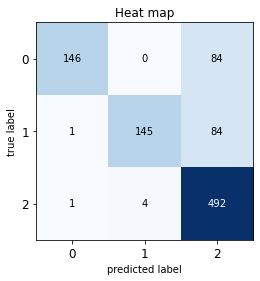

test F1 score: 0.796


In [29]:
eval_NN_model(model_ANN, X_test_padded, y_test)

#### RNN

In [30]:
chkpt2 = tf.keras.callbacks.ModelCheckpoint(
    'weights/RNN_weights', monitor='val_accuracy', verbose=0, save_best_only=True,
    save_weights_only=True
)

In [31]:
LSTM_UNITS = 50

model_RNN = Sequential()
model_RNN.add(Embedding(VOCAB_SIZE+1, EMB_DIM, input_length = X_train_padded.shape[1]))
model_RNN.add(LSTM(units = LSTM_UNITS, return_sequences = True))
model_RNN.add(LSTM(units = LSTM_UNITS))
model_RNN.add(Dense(CLASS_NUM, activation = 'softmax'))

model_RNN.compile(loss = 'categorical_crossentropy', 
                  optimizer = 'adam', metrics = ['accuracy'])
model_RNN.summary()

Model: "sequential_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding_1 (Embedding)      (None, 431, 50)           767600    
_________________________________________________________________
lstm (LSTM)                  (None, 431, 50)           20200     
_________________________________________________________________
lstm_1 (LSTM)                (None, 50)                20200     
_________________________________________________________________
dense_3 (Dense)              (None, 3)                 153       
Total params: 808,153
Trainable params: 808,153
Non-trainable params: 0
_________________________________________________________________


In [32]:
start = time.time()
history2 = model_RNN.fit(X_train_padded, y_train, validation_data = (X_test_padded, y_test),
          epochs = eps, batch_size = 32, shuffle = True, callbacks = [es, chkpt2])
end = time.time()
print('Took {:.3f} seconds to train'.format(end-start))

Epoch 1/100


C:\Users\moein\AppData\Roaming\Python\Python37\site-packages\tensorflow\python\data\ops\dataset_ops.py:3704: UserWarning: Even though the `tf.config.experimental_run_functions_eagerly` option is set, this option does not apply to tf.data functions. To force eager execution of tf.data functions, please use `tf.data.experimental.enable.debug_mode()`.
  "Even though the `tf.config.experimental_run_functions_eagerly` "


70/70 [==============================] - 6s 68ms/step - loss: 1.0060 - accuracy: 0.5316 - val_loss: 0.8916 - val_accuracy: 0.5987
Epoch 2/100
70/70 [==============================] - 5s 65ms/step - loss: 0.5565 - accuracy: 0.7340 - val_loss: 0.9274 - val_accuracy: 0.6082
Epoch 3/100
70/70 [==============================] - 4s 64ms/step - loss: 0.2714 - accuracy: 0.8854 - val_loss: 1.1106 - val_accuracy: 0.5987
Epoch 4/100
70/70 [==============================] - 4s 64ms/step - loss: 0.0942 - accuracy: 0.9713 - val_loss: 1.1302 - val_accuracy: 0.6479
Epoch 5/100
70/70 [==============================] - 4s 64ms/step - loss: 0.0315 - accuracy: 0.9946 - val_loss: 1.2178 - val_accuracy: 0.6938
Epoch 6/100
70/70 [==============================] - 5s 65ms/step - loss: 0.0194 - accuracy: 0.9973 - val_loss: 1.1748 - val_accuracy: 0.7043
Epoch 7/100
70/70 [==============================] - 4s 64ms/step - loss: 0.0157 - accuracy: 0.9973 - val_loss: 1.1008 - val_accuracy: 0.7200
Epoch 8/100
70/70 

In [33]:
model_RNN.load_weights('weights/RNN_weights')

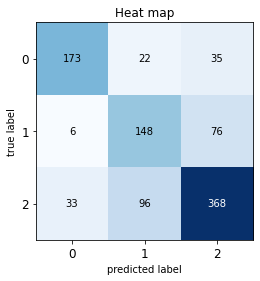

test F1 score: 0.711


In [34]:
eval_NN_model(model_RNN, X_test_padded, y_test)

#### CNN

In [35]:
chkpt3 = tf.keras.callbacks.ModelCheckpoint(
    'weights/CNN_weights', monitor='val_accuracy', verbose=0, save_best_only=True,
    save_weights_only=True
)

In [36]:
model_CNN = Sequential()
model_CNN.add(Embedding(VOCAB_SIZE+1, EMB_DIM, input_length = X_train_padded.shape[1]))
model_CNN.add(Conv1D(filters = 100, kernel_size = 3, activation='relu'))
model_CNN.add(MaxPool1D(pool_size = 2, strides=2))
model_CNN.add(Flatten())
model_CNN.add(Dropout(0.5))
model_CNN.add(Dense(CLASS_NUM, activation= 'softmax'))

model_CNN.compile(loss = 'categorical_crossentropy', 
                  optimizer = 'adam', metrics = ['accuracy'])
model_CNN.summary()

Model: "sequential_2"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding_2 (Embedding)      (None, 431, 50)           767600    
_________________________________________________________________
conv1d (Conv1D)              (None, 429, 100)          15100     
_________________________________________________________________
max_pooling1d (MaxPooling1D) (None, 214, 100)          0         
_________________________________________________________________
flatten_1 (Flatten)          (None, 21400)             0         
_________________________________________________________________
dropout (Dropout)            (None, 21400)             0         
_________________________________________________________________
dense_4 (Dense)              (None, 3)                 64203     
Total params: 846,903
Trainable params: 846,903
Non-trainable params: 0
________________________________________________

In [37]:
start = time.time()
history3 = model_CNN.fit(X_train_padded, y_train, validation_data = (X_test_padded, y_test),
          epochs = eps, batch_size = 32, shuffle = True, callbacks = [es, chkpt3])
end = time.time()
print('Took {:.3f} seconds to train'.format(end-start, eps))

Epoch 1/100


C:\Users\moein\AppData\Roaming\Python\Python37\site-packages\tensorflow\python\data\ops\dataset_ops.py:3704: UserWarning: Even though the `tf.config.experimental_run_functions_eagerly` option is set, this option does not apply to tf.data functions. To force eager execution of tf.data functions, please use `tf.data.experimental.enable.debug_mode()`.
  "Even though the `tf.config.experimental_run_functions_eagerly` "


70/70 [==============================] - 4s 39ms/step - loss: 1.0195 - accuracy: 0.5137 - val_loss: 0.9844 - val_accuracy: 0.5193
Epoch 2/100
70/70 [==============================] - 3s 41ms/step - loss: 0.7254 - accuracy: 0.6561 - val_loss: 0.5497 - val_accuracy: 0.8161
Epoch 3/100
70/70 [==============================] - 3s 41ms/step - loss: 0.1434 - accuracy: 0.9749 - val_loss: 0.3770 - val_accuracy: 0.8662
Epoch 4/100
70/70 [==============================] - 3s 41ms/step - loss: 0.0207 - accuracy: 0.9982 - val_loss: 0.3941 - val_accuracy: 0.8621
Epoch 5/100
70/70 [==============================] - 3s 40ms/step - loss: 0.0093 - accuracy: 0.9991 - val_loss: 0.3649 - val_accuracy: 0.8715
Epoch 6/100
70/70 [==============================] - 3s 42ms/step - loss: 0.0048 - accuracy: 0.9996 - val_loss: 0.3675 - val_accuracy: 0.8725
Epoch 7/100
70/70 [==============================] - 3s 41ms/step - loss: 0.0042 - accuracy: 0.9996 - val_loss: 0.3717 - val_accuracy: 0.8715
Epoch 8/100
70/70 

In [38]:
model_CNN.load_weights('weights/CNN_weights')

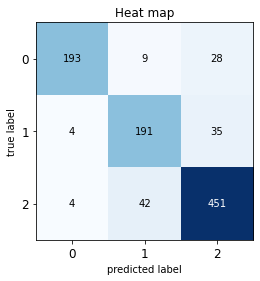

test F1 score: 0.866


In [39]:
eval_NN_model(model_CNN, X_test_padded, y_test)